# ExMachina example

**Please follow preparation instruction in `README.md` in advance.**

This notebook needs some Jupyter Lab extensions.

In [ ]:
!jupyter labextension install @jupyter-widgets/jupyterlab-manager
!jupyter labextension install @jupyterlab/fasta-extension
!jupyter labextension install nglview-js-widgets

In this example, the query is SCOP [1] domain `d1qg3a1` and the template is `d1va9a1`.

* `d1qg3a1` (https://scop.berkeley.edu/sunid=21993&ver=1.75)
  * b.1.2.1 Integrin beta-4 subunit {Human (Homo sapiens) [TaxId: 9606]}
* `d1va9a1` (https://scop.berkeley.edu/sunid=119904&ver=1.75)
  * b.1.2.1 Down syndrome cell adhesion molecule-like protein 1, DSCAML1 {Human (Homo sapiens) [TaxId: 9606]}

1. Murzin A. G., Brenner S. E., Hubbard T., Chothia C. (1995). SCOP: a structural classification of proteins database for the investigation of sequences and structures. <i>J. Mol. Biol.</i> 247, 536-540.

In [1]:
from pathlib import Path
from IPython.display import display

display({
    'application/vnd.fasta.fasta': ''.join([
        Path('tests/data/d1qg3a1.fasta').read_text(),
        Path('tests/data/d1va9a1.fasta').read_text()
    ])
}, raw=True)

## Create profile (ASCII PSSM)

In [ ]:
!python3 exmachina.py create-profile tests/data/d1qg3a1.fasta tests/data/d1va9a1.fasta

Profile creation requires BLAST (`psiblast`) and the database (UniRef90 is recommended).

So, sample PSSMs are available in `tests/data`.

In [14]:
!head tests/data/d1qg3a1.mtx
!head tests/data/d1va9a1.mtx


Last position-specific scoring matrix computed, weighted observed percentages rounded down, information per position, and relative weight of gapless real matches to pseudocounts
            A   R   N   D   C   Q   E   G   H   I   L   K   M   F   P   S   T   W   Y   V   A   R   N   D   C   Q   E   G   H   I   L   K   M   F   P   S   T   W   Y   V
    1 D    -2  -2   2   6  -4  -1   2  -2  -2  -4  -4  -1  -4  -4  -2  -1  -2  -5  -4  -4    0   0   9  78   0   0  13   0   0   0   0   0   0   0   0   0   0   0   0   0  1.09 0.13
    2 L    -4  -6  -6  -5  -6  -5  -5  -6  -6  -1   2  -5   1  -6   8  -5  -4  -7  -6  -3    0   0   0   0   0   0   0   0   0   3  18   0   3   0  74   0   0   0   0   1  2.18 0.65
    3 G     5  -4  -3  -4  -4  -3  -4   4  -3  -4  -2  -2  -4  -2  -4   1  -3  -5  -1  -2   46   0   1   0   0   0   0  33   0   0   4   1   0   1   0   9   0   0   2   2  0.92 0.42
    4 A     5  -4  -3  -4  -5  -3   0  -4  -5  -5  -5  -4  -5  -5   6   0  -4  -6  -4  -4   43   0   1   

## Predict substitution score

Before that, download <i>k</i>NN index and data.

The size of `small` data is approximately 430MB and for testing. 

In [ ]:
!dvc get . knn_index/small

`medium` is about 4.2GB.

In [ ]:
!dvc get . knn_index/medium

In [15]:
%ls small medium

medium:
flann19_scop40_logscore_tmscore0.5_window5_ratio0.1
scop40_logscore_tmscore0.5_window5_ratio0.1_x.npy
scop40_logscore_tmscore0.5_window5_ratio0.1_y.npy

small:
flann19_scop40_logscore_tmscore0.5_window5_ratio0.01
scop40_logscore_tmscore0.5_window5_ratio0.01_x.npy
scop40_logscore_tmscore0.5_window5_ratio0.01_y.npy


Prediction consumes 24GB RAM in the case of `medium` size data.

In [ ]:
!python3 exmachina.py predict-scores tests/data/d1qg3a1.mtx tests/data/d1va9a1.mtx

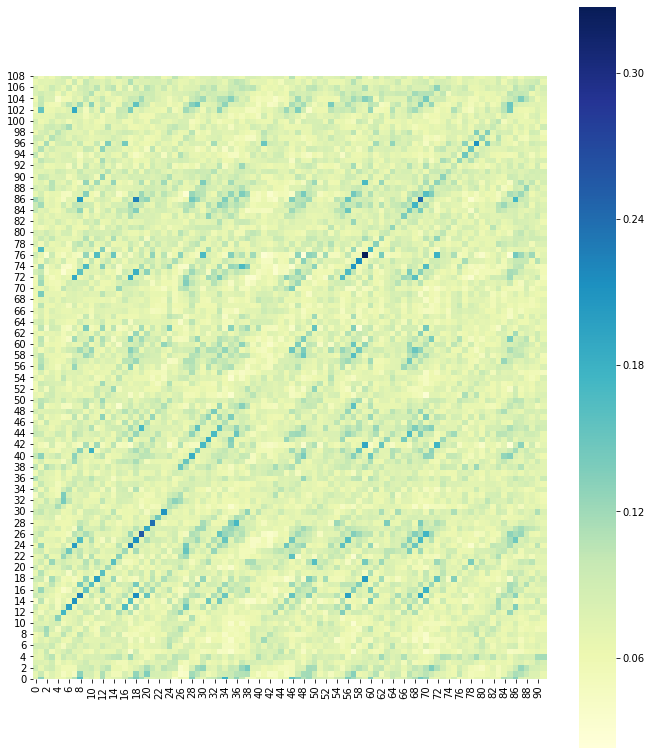

In [27]:
%matplotlib inline

import numpy as np
from matplotlib import pyplot
import seaborn

labels = np.load(f'results/score.npy')
fig, ax = pyplot.subplots(figsize=(labels.shape[0]/8, labels.shape[1]/8))
seaborn.heatmap(labels.T, ax=ax, linewidths=0, square=True, cmap="YlGnBu").invert_yaxis()

## Generate pairwise alignments

In [26]:
!python3 exmachina.py generate-alignment tests/data/d1qg3a1.mtx tests/data/d1va9a1.mtx results/score.npy

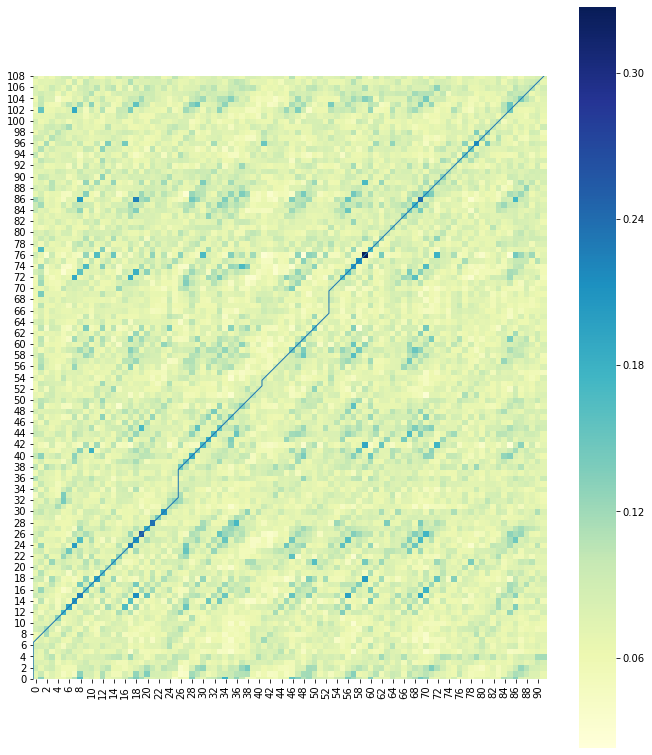

In [33]:
%matplotlib inline

from Bio.SeqRecord import SeqRecord
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.Align import MultipleSeqAlignment
from matplotlib import pyplot
import seaborn as sns
from IPython.display import display
import numpy as np


def alignment_graph(alignment):
    assert len(alignment[0]) == len(alignment[1])
    x, y = [0], [0]
    for i in range(len(alignment[0])):
        if alignment[0][i] == '-':
            x.append(x[-1])
            y.append(y[-1] + 1)
        elif alignment[1][i] == '-':
            x.append(x[-1] + 1)
            y.append(y[-1])
        else:
            x.append(x[-1] + 1)
            y.append(y[-1] + 1)
    return np.array(x), np.array(y)

labels = np.load('results/score.npy')
aln = np.load('results/alignments.npy')[0]
x, y = alignment_graph(MultipleSeqAlignment([SeqRecord(Seq(aln[0])), SeqRecord(Seq(aln[1]))]))
fig, ax = pyplot.subplots(figsize=(labels.shape[0]/8, labels.shape[1]/8))
sns.heatmap(labels.T, ax=ax, linewidths=0, square=True, cmap="YlGnBu").invert_yaxis()
ax.plot(x, y, linewidth=1)
display({
    'application/vnd.fasta.fasta': ''.join([
        SeqRecord(Seq(aln[0]), id='d1qg3a1').format('fasta'),
        SeqRecord(Seq(aln[1]), id='d1va9a1').format('fasta')
    ])
}, raw=True)

## Make models

Model generation requires MODELLER.

Template structure is available in `tests/data` as sample.

In [47]:
!ls tests/data/*.ent

tests/data/d1va9a1.ent


In [50]:
!python3 exmachina.py generate-model /usr/local/opt/modeller/bin/mod9.22 tests/data/d1qg3a1.mtx tests/data/d1va9a1.mtx A results/alignments.npy tests/data

In [35]:
!ls -s1 results/

total 1712
   8 alignment.pir
   8 alignments.npy
 112 d1qg3a1.B99990001.pdb
  40 d1qg3a1.D00000001
  96 d1qg3a1.V99990001
 112 d1qg3a1.ini
1152 d1qg3a1.rsr
   8 d1qg3a1.sch
  16 modeller.log
 160 score.npy


### Visualize

Native structure is available in `tests/data` for comparison.

In [34]:
!ls -1 tests/data/*.ent

tests/data/d1qg3a1.ent
tests/data/d1va9a1.ent


In [3]:
import nglview

nglview.show_file('tests/data/d1qg3a1.ent')

NGLWidget()

In [4]:
nglview.show_file('results/d1qg3a1.B99990001.pdb')

NGLWidget()